# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
37343,37343,France,"This is a warm wine with a rounded feel, makin...",NaN,90,27.0,Burgundy,Côte de Beaune-Villages,NaN,Roger Voss,@vossroger,David Moreau 2011 Côte de Beaune-Villages,Pinot Noir,David Moreau
105078,105078,Georgia,"A blend of two indigenous Georgian grapes, thi...",Kondoli Single Vineyard Mtsvane-Kisi,89,14.0,Kakheti,NaN,NaN,Mike DeSimone,@worldwineguys,Marani 2014 Kondoli Single Vineyard Mtsvane-Ki...,White Blend,Marani
120739,120739,Spain,Earthy gritty berry aromas come with a hint of...,El Circo Volatinero,86,8.0,Northern Spain,Cariñena,NaN,Michael Schachner,@wineschach,Grandes Vinos y Viñedos 2015 El Circo Volatine...,Tempranillo,Grandes Vinos y Viñedos
122872,122872,Austria,Appetizing notes of Cox Orange Pippin and ripe...,NaN,91,20.0,Vienna,NaN,NaN,Anne Krebiehl MW,@AnneInVino,Wieninger 2016 Riesling (Vienna),Riesling,Wieninger
63443,63443,Italy,"Aromas of blue flower, ripe berry and allspice...",Altemura,89,29.0,Southern Italy,Primitivo di Manduria,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Altemura 2012 Altemura (Primitivo di...,Primitivo,Masseria Altemura


In [49]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [51]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [52]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [53]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [55]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [56]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.453661
MAE    2.524091
R2    -0.000014
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [57]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.657414
Armenia                   87.500000
Australia                 88.596154
Austria                   90.089860
Bosnia and Herzegovina    88.000000
Name: points, dtype: float64

In [58]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    8.959800
MAE    2.450059
R2     0.052227
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [59]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.775961
           Other               85.932500
Armenia    Armenia             87.500000
Australia  Australia Other     85.461538
           New South Wales     87.828571
Name: basiline_3_predicted_points, dtype: float64

In [60]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [61]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.423995
MAE    2.357004
R2     0.108905
dtype: float64

### Baselines summary

In [63]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.453661,2.524091,-0.000014
baseline_2,8.959800,2.450059,0.052227
baseline_3,8.423995,2.357004,0.108905


In [16]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [64]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [65]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [66]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [21]:
from src.models import i_feel_lucky_xgboost_training

In [67]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int64  
 1   province     95990 non-null  int64  
 2   region_1     95990 non-null  int64  
 3   region_2     95990 non-null  int64  
 4   taster_name  95990 non-null  int64  
 5   variety      95990 non-null  int64  
 6   winery       95990 non-null  int64  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 7.3 MB


In [68]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [69]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
13,22,332,424,6,9,388,10819,-1.0,87,87
15,17,232,738,6,1,480,13236,24.0,87,90
16,0,270,151,6,12,280,7274,30.0,87,88
20,41,399,1201,6,0,474,12968,23.0,87,86
23,41,51,800,1,11,326,1234,22.0,87,88


In [70]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.306234
MAE    1.898533
R2     0.332923
dtype: float64

In [71]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.453661,2.524091,-0.000014
baseline_2,8.959800,2.450059,0.052227
baseline_3,8.423995,2.357004,0.108905
regression_by_xgb,6.306234,1.898533,0.332923


In [72]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Using both the text and other features

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [29]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    71.0
Name: description, dtype: float64

In [37]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [38]:
vectorize_layer.adapt(train_data['description'])

2022-05-12 13:46:53.061584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [39]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Made with dried Garganega grapes, this has delicate aromas suggesting dried white flowers, ripe fig and a whiff of cake spice. The rounded palate offers mature apricot, acacia honey and light touch of cinnamon.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([  99,    6,   86, 4188,  239,    7,   30,  263,   17,  712,   86,
         55,  339,   27,  599,    2,    4,  304,    5,  713,   34,    3,
        262,   18,   52,  260,  196, 1247,  186,    2,   58,   80,    5,
        213,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [40]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

99 --->  made
6 --->  with
86 --->  dried
4188 --->  garganega
239 --->  grapes
7 --->  this
30 --->  has
263 --->  delicate
17 --->  aromas
712 --->  suggesting
86 --->  dried
55 --->  white
339 --->  flowers
27 --->  ripe
599 --->  fig
2 --->  and
4 --->  a
304 --->  whiff
5 --->  of
713 --->  cake


#### Modeling

In [76]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_4 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

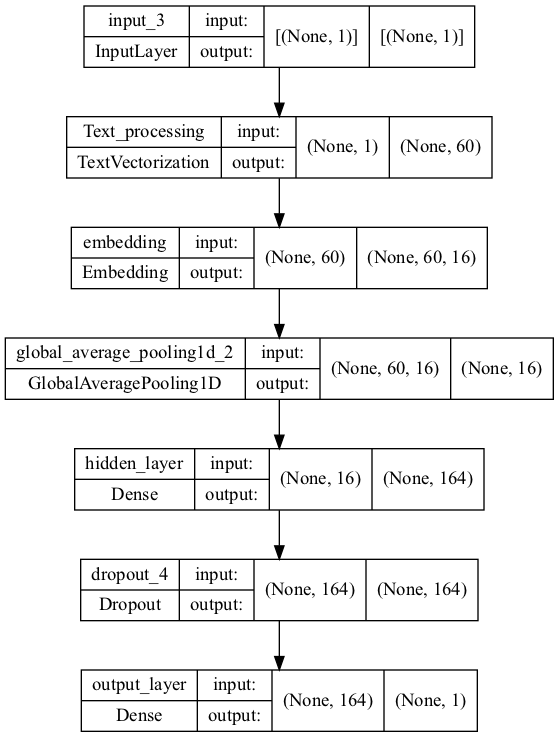

In [78]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [82]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [90]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 12s 16ms/step - loss: 1.1590 - mean_squared_error: 2.3415 - mean_absolute_error: 1.1590 - val_loss: 1.4263 - val_mean_squared_error: 3.2950 - val_mean_absolute_error: 1.4263
Epoch 2/20
750/750 [==============================] - 12s 16ms/step - loss: 1.1462 - mean_squared_error: 2.3035 - mean_absolute_error: 1.1462 - val_loss: 1.4105 - val_mean_squared_error: 3.2304 - val_mean_absolute_error: 1.4105
Epoch 3/20
750/750 [==============================] - 12s 16ms/step - loss: 1.1375 - mean_squared_error: 2.2758 - mean_absolute_error: 1.1375 - val_loss: 1.4175 - val_mean_squared_error: 3.2595 - val_mean_absolute_error: 1.4175
Epoch 4/20
750/750 [==============================] - 12s 16ms/step - loss: 1.1261 - mean_squared_error: 2.2427 - mean_absolute_error: 1.1261 - val_loss: 1.3938 - val_mean_squared_error: 3.1577 - val_mean_absolute_error: 1.3938
Epoch 5/20
750/750 [==============================] - 12s 16ms/step - loss: 1.1166 - mea

### Simple NN Prediction & Evaluation

In [91]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [93]:
calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    3.110906
MAE    1.383892
R2     0.670926
dtype: float64

### Descriptions words concatinated

In [94]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [121]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [122]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

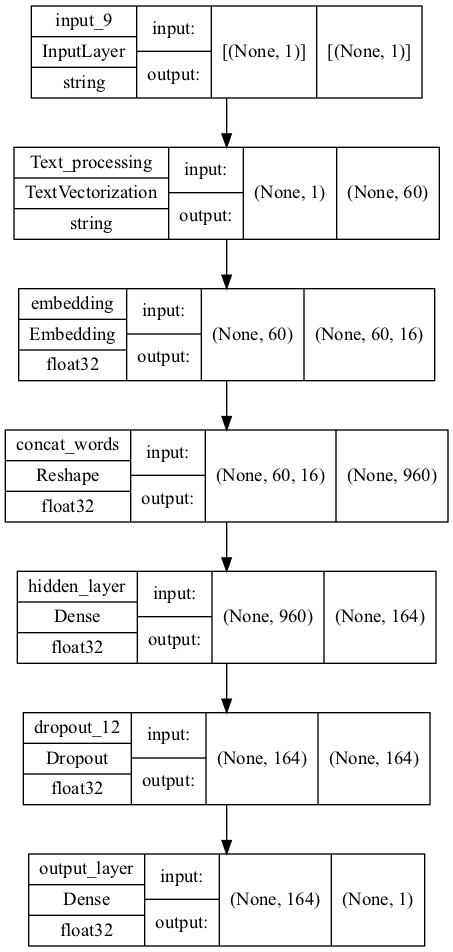

In [123]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [124]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
  1/750 [..............................] - ETA: 4:22 - loss: 88.7070 - mean_squared_error: 7877.8853 - mean_absolute_error: 88.7070

2022-05-12 14:53:36.263701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 23.8149 - mean_squared_error: 1083.5869 - mean_absolute_error: 23.8149

2022-05-12 14:53:48.723508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 13s 17ms/step - loss: 23.8149 - mean_squared_error: 1083.5869 - mean_absolute_error: 23.8149 - val_loss: 2.6054 - val_mean_squared_error: 10.3920 - val_mean_absolute_error: 2.6054
Epoch 2/20
750/750 [==============================] - 13s 17ms/step - loss: 6.7823 - mean_squared_error: 79.9328 - mean_absolute_error: 6.7823 - val_loss: 2.6412 - val_mean_squared_error: 10.7738 - val_mean_absolute_error: 2.6412
Epoch 3/20
750/750 [==============================] - 12s 17ms/step - loss: 5.2717 - mean_squared_error: 53.8358 - mean_absolute_error: 5.2717 - val_loss: 2.5942 - val_mean_squared_error: 10.2882 - val_mean_absolute_error: 2.5942
Epoch 4/20
750/750 [==============================] - 12s 16ms/step - loss: 3.9429 - mean_squared_error: 34.3796 - mean_absolute_error: 3.9429 - val_loss: 1.4725 - val_mean_squared_error: 3.4387 - val_mean_absolute_error: 1.4725
Epoch 5/20
750/750 [==============================] - 12s 17ms/step - loss: 2.8035 - mea

In [125]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

2022-05-12 14:55:28.990416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [126]:
calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    2.895544
MAE    1.343375
R2     0.693708
dtype: float64